<a href="https://colab.research.google.com/github/nbhushan/ColabSandbox/blob/main/XAI_DataLab2_SaliencyMaps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#load libraries

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist

from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions

# install LIME package
!pip install lime
!pip install tf-explain
!pip install opencv-python

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
from lime.wrappers.scikit_image import SegmentationAlgorithm
import matplotlib.pyplot as plt
import random

In [ ]:
# pre-process data

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.reshape((-1,28,28,1)).astype('float32') / 255.0

x_test = x_test.reshape((-1,28,28,1)).astype('float32') / 255.0



import numpy as np
def to_rgb(x):
    x_rgb = np.zeros((x.shape[0], 28, 28, 3))
    for i in range(3):
        x_rgb[..., i] = x[..., 0]
    return x_rgb
x_train = to_rgb(x_train)
x_test = to_rgb(x_test)

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
print("Fashion MNIST train -  images:",x_train.shape[0]," image shape:", x_train.shape[1:4])
print("Fashion MNIST test -  images:",x_test.shape[0]," image shape:", x_test.shape[1:4])

Fashion MNIST train -  images: 60000  image shape: (28, 28, 3)
Fashion MNIST test -  images: 10000  image shape: (28, 28, 3)


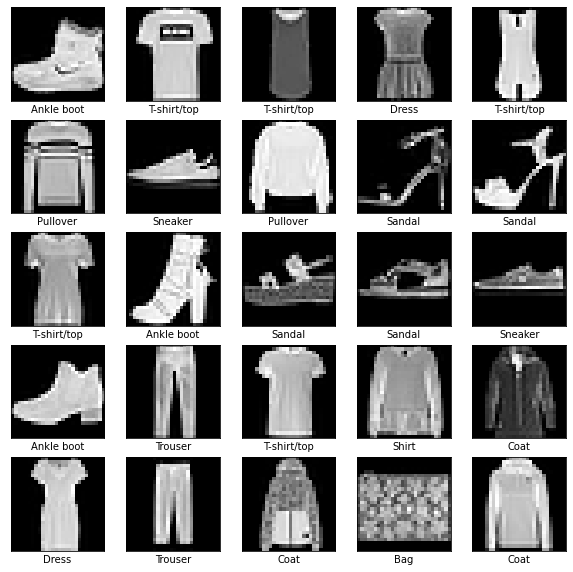

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(class_names[y_train[i]])
plt.show()

In [ ]:
# build a simple dense NN 

mod_NN = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
    ])

print(mod_NN.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 2352)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               301184    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 302,474
Trainable params: 302,474
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# compile the model

mod_NN.compile(
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer=keras.optimizers.Adam(),
  metrics=['accuracy']
)

In [ ]:
# fit (train) the model

mod_NN.fit(
        x_train, 
        y_train, 
        epochs=10, 
        batch_size=32)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1875/1875 [==============================] - 9s 5ms/step - loss: 0.5337 - accuracy: 0.8087
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4188 - accuracy: 0.8463
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3879 - accuracy: 0.8585
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3683 - accuracy: 0.8648
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3518 - accuracy: 0.8702
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3372 - accuracy: 0.8743
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3292 - accuracy: 0.8782
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3202 - accuracy: 0.8802
Epoch 9/10
1875/1875 [==============================] - 8s 5ms/step - loss: 0.3126 - accuracy: 0.8832
Epoch 10/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3043 - accurac

In [ ]:
test_loss, test_acc = mod_NN.evaluate(x_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


313/313 - 1s - loss: 0.3621 - accuracy: 0.8700 - 681ms/epoch - 2ms/step

Test accuracy: 0.8700000047683716


  0%|          | 0/5000 [00:00<?, ?it/s]

Text(0.5, 0, 'T-shirt/top')

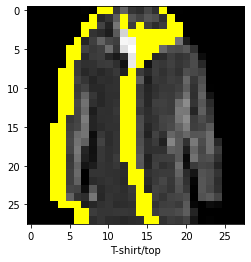

In [ ]:
#create LIME explanations

n = 19
explainer = lime_image.LimeImageExplainer(random_state=42)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)


explanation = explainer.explain_instance(
         x_test[n], 
         mod_NN.predict,
         top_labels=5,
         num_samples=5000,
         segmentation_fn=segmenter 
)


plt.imshow(x_test[n])
img = x_test[n].reshape((1,28,28,3))
label =  mod_NN.predict(img).argmax()
image, mask = explanation.get_image_and_mask(
         label,
         positive_only=True, 
         hide_rest=False)
plt.imshow(mark_boundaries(image, mask))
plt.xlabel(class_names[label])

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

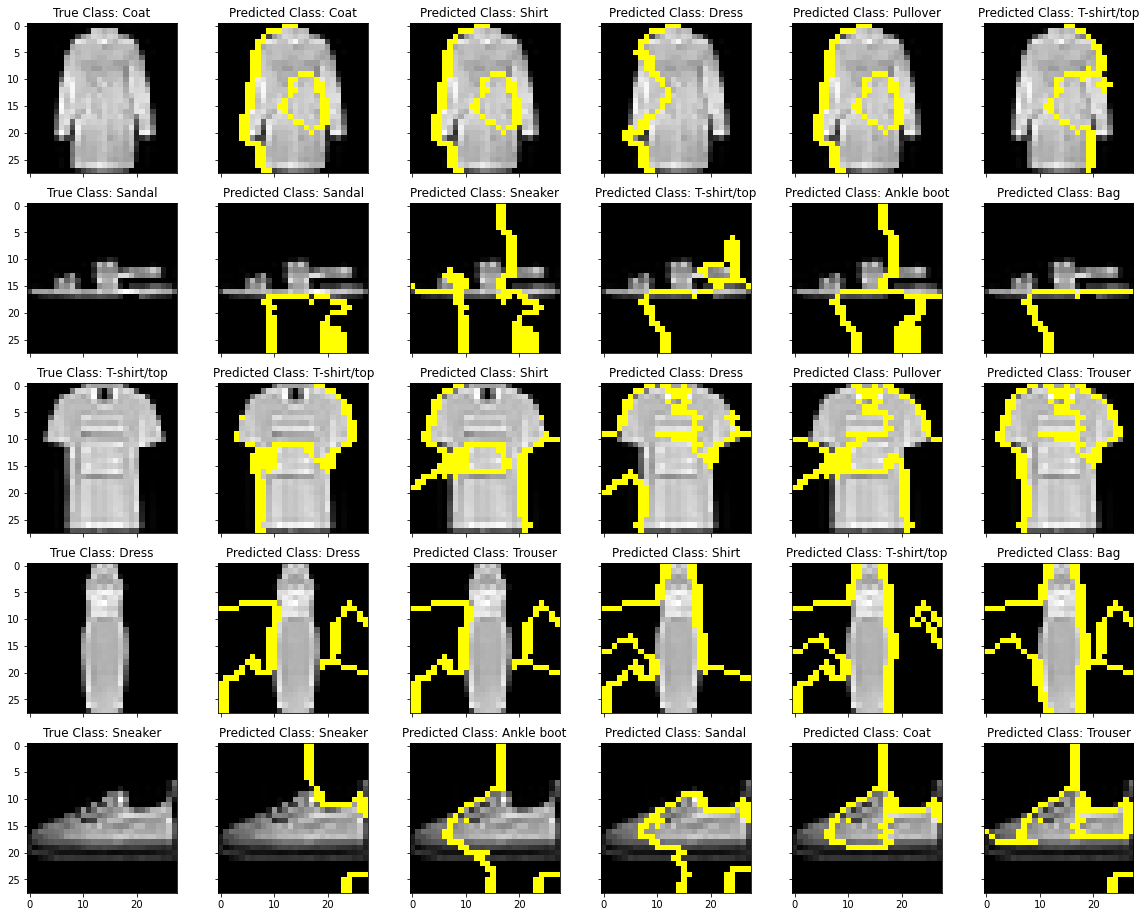

In [ ]:
fig, ax = plt.subplots(5, 6, sharex='col', sharey='row')
fig.set_figwidth(20)
fig.set_figheight(16)
indecies = random.sample(range(x_test.shape[0]), 5)

explainer = lime_image.LimeImageExplainer(random_state=42)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)


for j in range(5):
    explanation = explainer.explain_instance(x_test[indecies[j]], 
                                             mod_NN.predict, 
                                             top_labels=5, 
                                             hide_color=0, 
                                             num_samples=1000, 
                                             segmentation_fn=segmenter,
                                             random_seed=42)
    ax[j,0].imshow(x_test[indecies[j]])
    ax[j,0].set_title("True Class: " + class_names[y_test[indecies[j]]])
    for i in range(5):
      img = x_test[indecies[j]].reshape((1,28,28,3))
      label = np.flip(mod_NN.predict(img).argsort(axis=1))[0][i]
      image, mask = explanation.get_image_and_mask(label,
                                                   positive_only=True, 
                                                   hide_rest=False)
      ax[j, i+1].imshow(mark_boundaries(image, mask))
      ax[j,i+1].set_title("Predicted Class: " + class_names[label])


# SALIENCY MAPS

In [ ]:
from tf_explain.core.vanilla_gradients import VanillaGradients

n = 19


explainer = VanillaGradients()

img = x_test[n].reshape((1,28,28,3))
data = ([img], None)

grid = explainer.explain(data, mod_NN, y_test[n])
explainer.save(grid, ".", "vanilla_gradients.png")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Unsupported model architecture for VanillaGradients. The last two layers of the model should be: a layer which computes class scores with no activation, followed by an activation layer.
  # This is added back by InteractiveShellApp.init_path()


ValueError: ignored